In [418]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import glob
import os
import numpy as np

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [487]:
# get h5 datasets
data,jet_tables = utils.get_training_data_jets("../../data/dijet_tight/*data.h5")
data.head()

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/5_data.h5'
data_loader :: Grabbing dataset with keys [u

,jetEta,jetPhi,jetPt,jetM,jetChargedFraction,jetPTD,jetAxis2
0,0.391208,3.126895,880.629578,46.972202,0.941176,0.238104,0.041430
1,0.226281,1.619783,839.069214,27.909035,0.631579,0.254852,0.016366
2,1.215448,0.042642,1736.550293,164.827713,0.608696,0.418112,0.006629
3,-0.121109,-1.891376,453.773132,62.488964,0.771429,0.162267,0.079624
4,1.025759,3.117460,882.341492,160.383484,0.600000,0.215028,0.021459


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train', 'test']


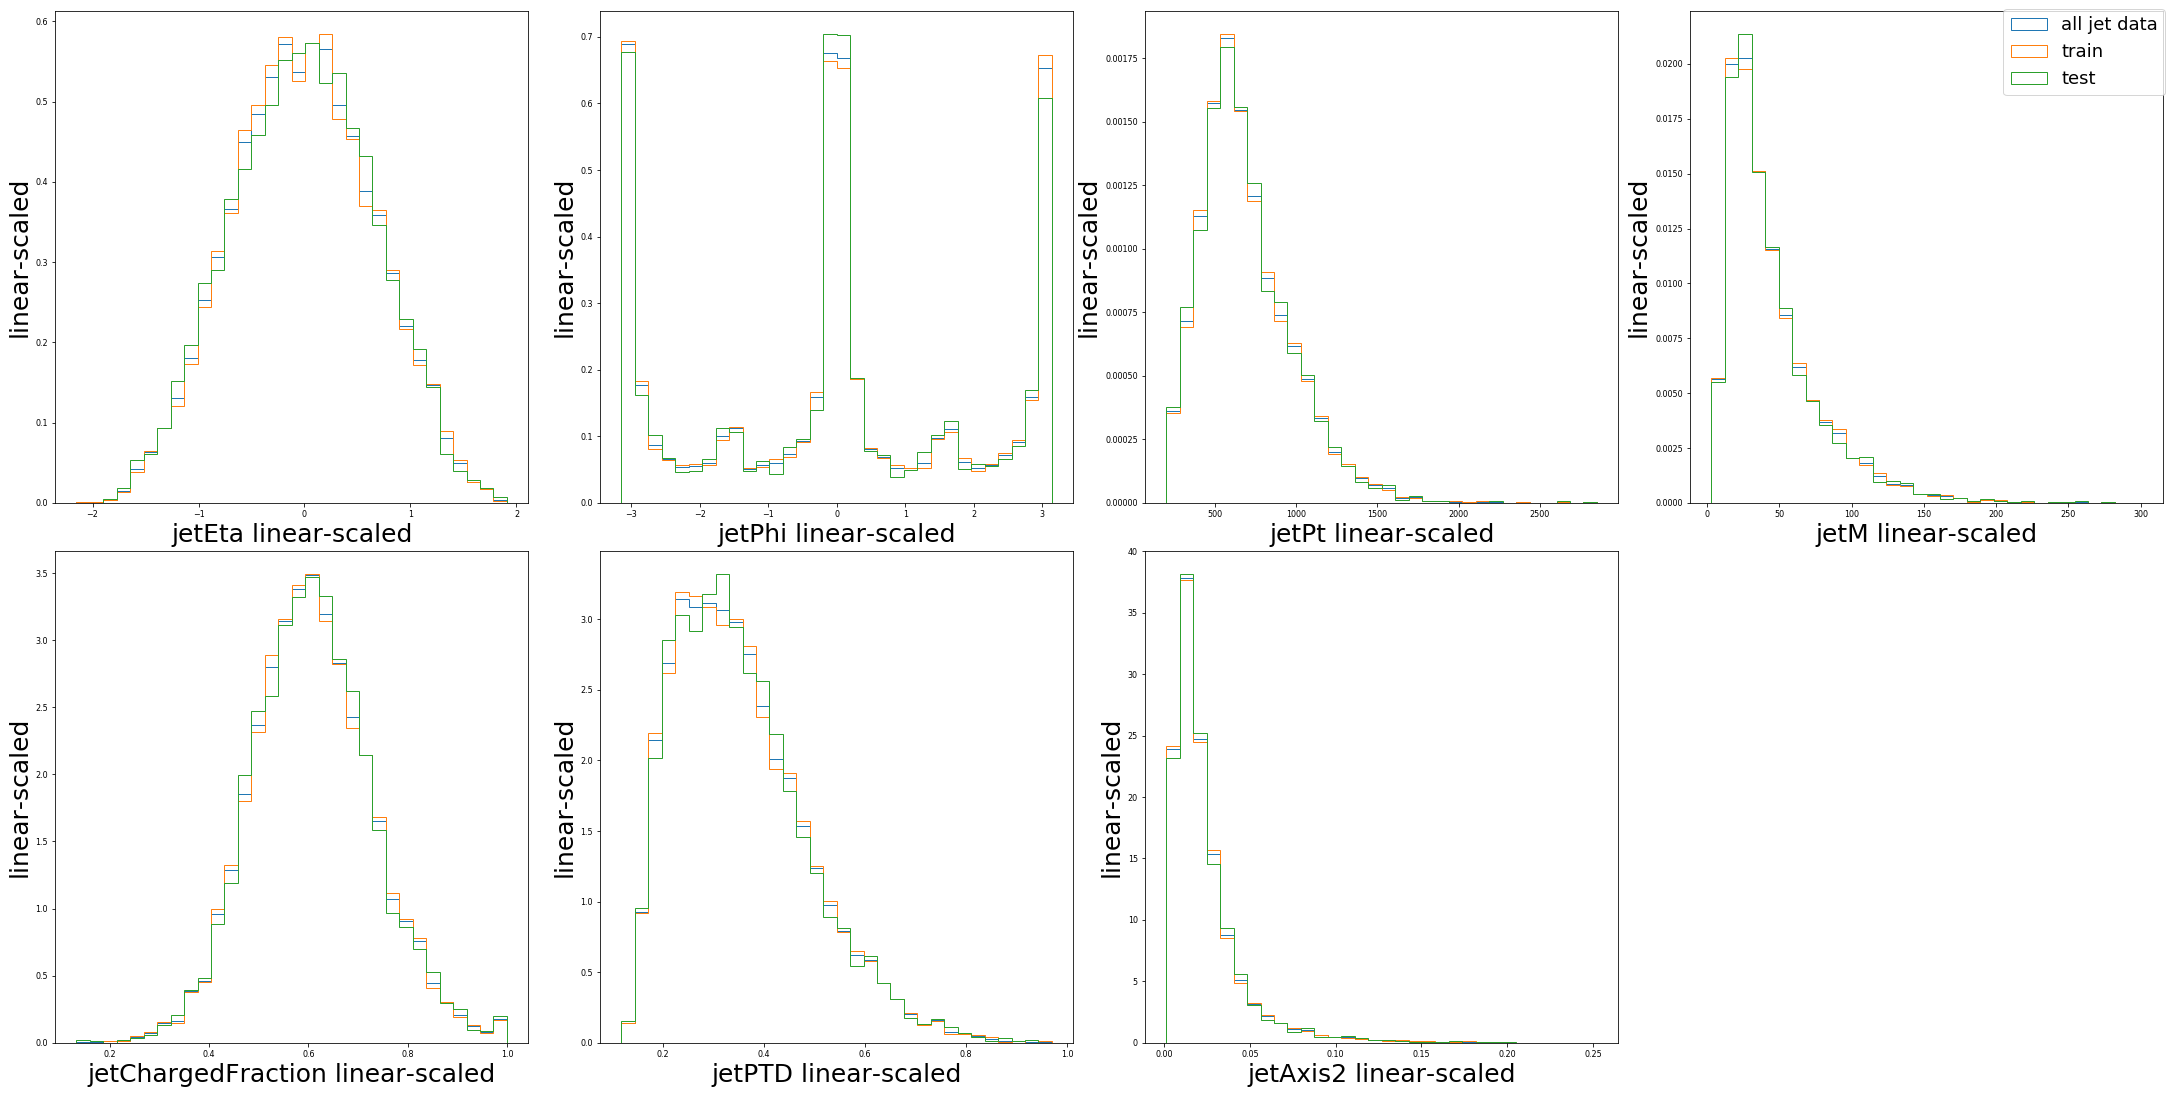

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'jet 0', 'jet 1']


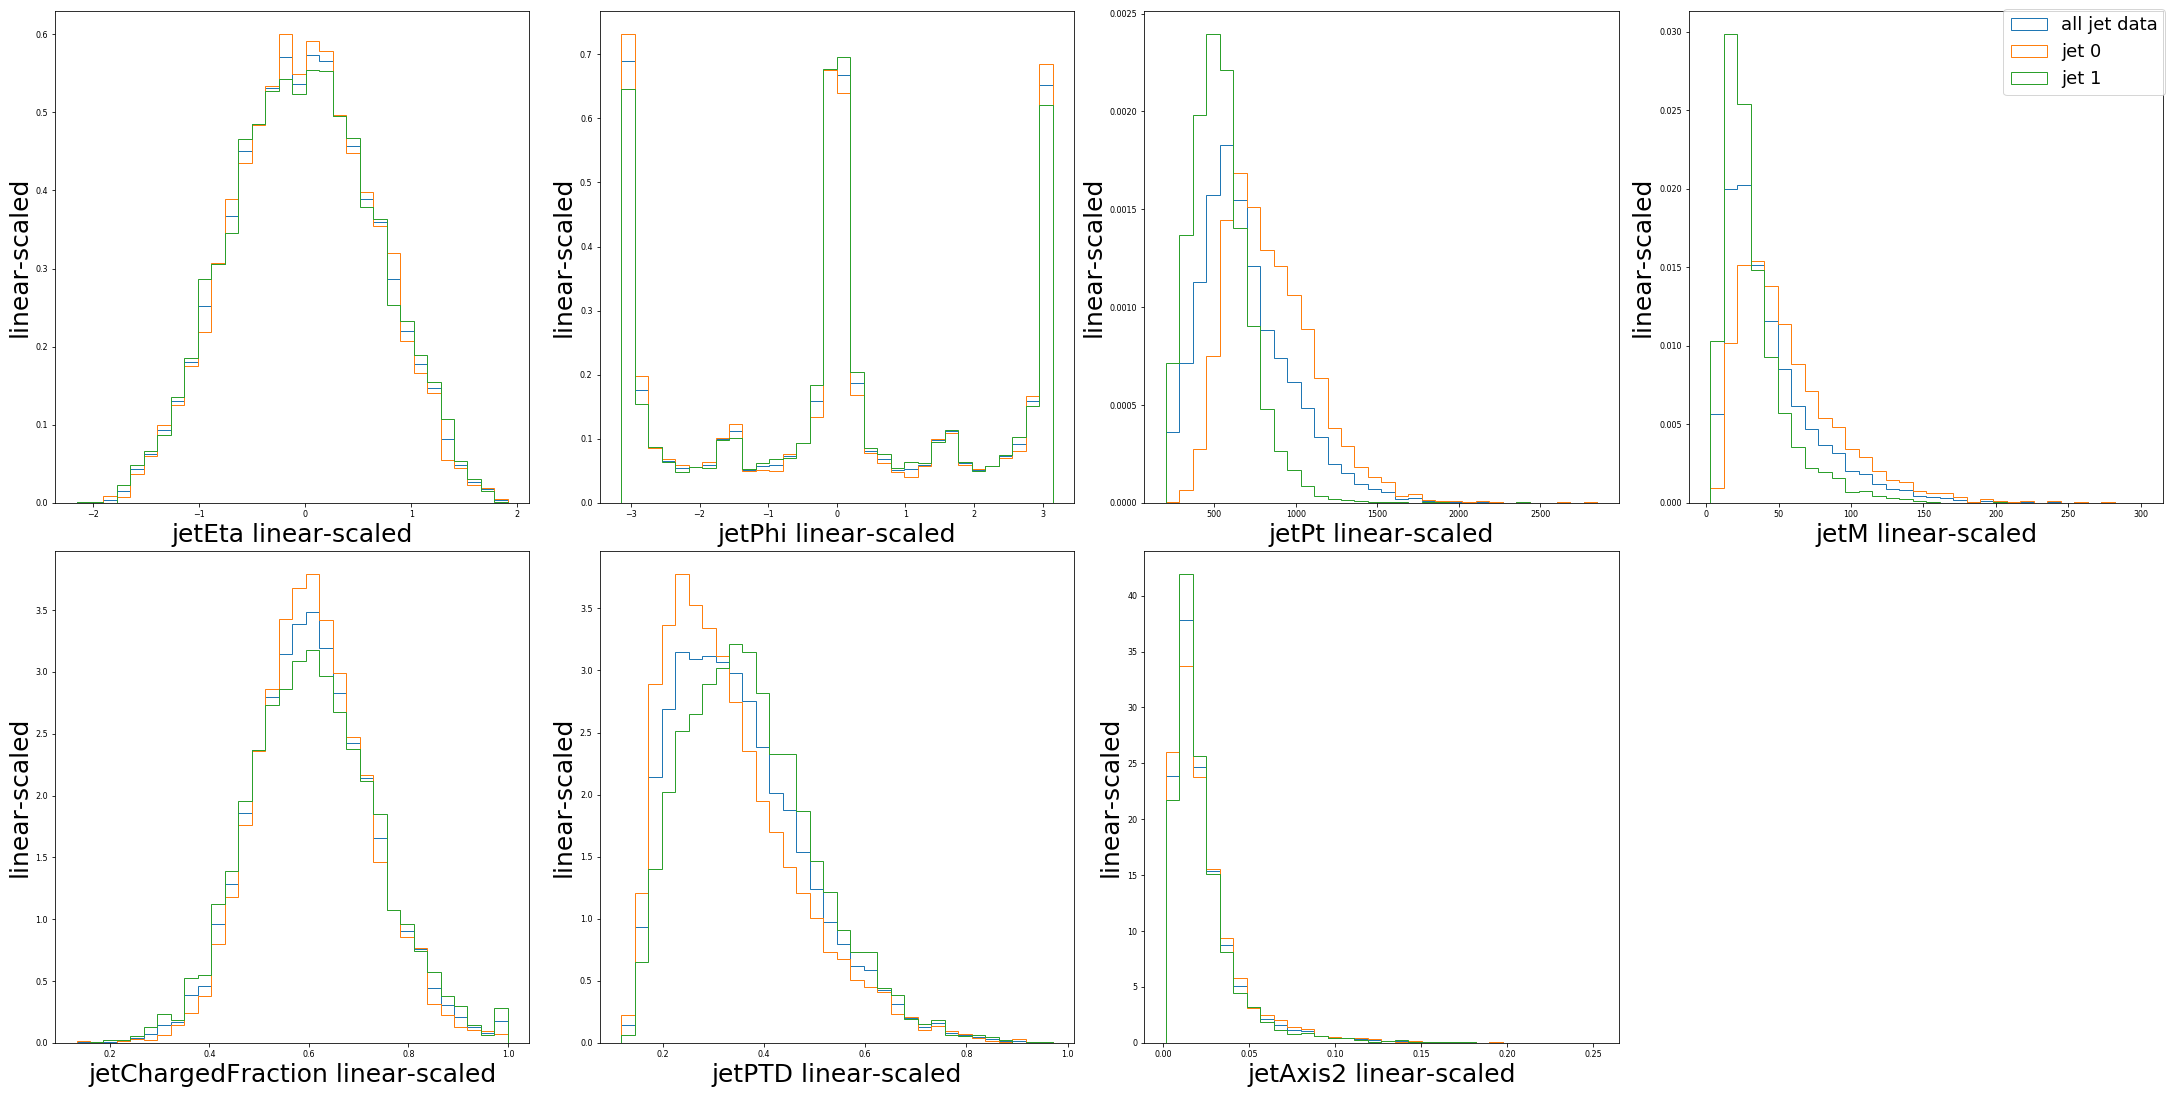

In [488]:
train, test = data.train_test_split(0.3)
data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


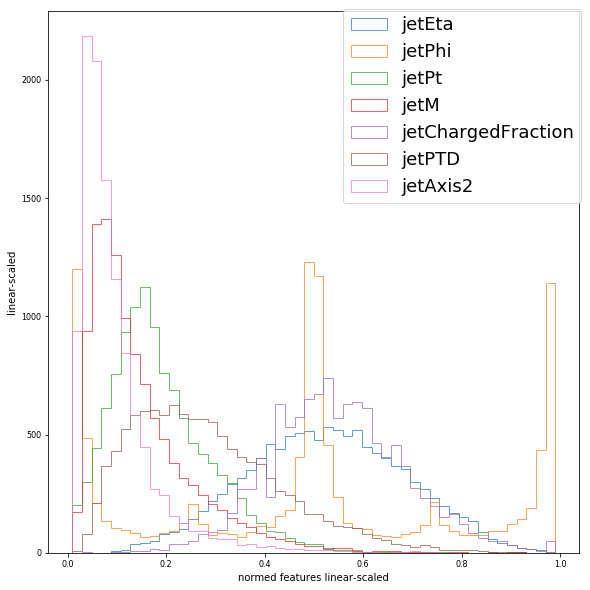

In [501]:
norm_args = {
    "norm_type": "MinMaxScaler",
    "feature_range": (0.01, 0.99)
}

norm_data = data.norm(**norm_args)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

train_norm, test_norm = data.norm(train, **norm_args), data.norm(test, **norm_args)


# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [502]:
# def delta(x):
#     if x == 0:
#         return 1.
#     return 0.

# def clipped_log_norm(X,A1,A2,A3):
#     ret = np.empty(X.shape)
#     for i in range(len(ret)):
#         x = X[i] 
#         a1 = A1[i] 
#         a2 = A2[i]
#         a3 = A3[i]
#         if a2 == 0:
#             ret[i] = 0
#         elif x >= 10.**(-4.):
#             ret[i] = a3*delta(x) + ((1. - a3)/(x*a2*np.sqrt(2.*np.pi)))*np.exp(-(np.log(x) - a1)**2./(2.*a2*a2))
#         else:
#             ret[i] = 0
#     return np.asarray(ret)

# def gaussian(X,A1,A2):
#     if not isinstance(X, np.ndarray):
#         X,A1,A2 = map(lambda x: np.asarray([x]), [X, A1, A2])
#     ret = np.empty(X.shape)
#     for i in range(len(ret)):
#         x,a1,a2 = X[i],A1[i],A2[i]
#         if a2 <= 0:
#             ret[i] = 0
#         else:
#             ret[i] = (1./(a2*np.sqrt(2.*np.pi)))*np.exp(-((x - a1)*(x - a1)/(2*a2*a2)))
#     return ret

# def phi_pdf(X, Dist, Frac, Sig1, Sig2):
#     ret = np.empty(X.shape)
#     for i in range(X.shape[0]):
#         x,dist,frac,sig1,sig2 = map(lambda x: x[i], [X,Dist,Frac,Sig1,Sig2])
#         if sig1 == 0 or sig2 == 0:
#             ret[i] = 0
#         else:
#             f1 = 1./frac
#             f2 = frac
#             ret[i] = f1*gaussian(x, 0, sig1) + f2*gaussian(x, 1.*dist, sig2) + f1*gaussian(x, 2.*dist, sig1) + f2*gaussian(x, 3.*dist, sig2) + f1*gaussian(x, 4.*dist, sig1)
#     return ret

# def loss_float(true, pred):
#     losses = np.asarray([
#         gaussian(true[0], pred[0], pred[1]),
#         phi_pdf(true[1], pred[2], pred[3], pred[4], pred[5]),
#         clipped_log_norm(true[2], pred[6], pred[7], pred[8]),
#         clipped_log_norm(true[3], pred[9], pred[10], pred[11]),
#         gaussian(true[4], pred[12], pred[13]),
#         clipped_log_norm(true[5], pred[14], pred[15], pred[16]),
#         clipped_log_norm(true[6], pred[17], pred[18], pred[19])
#     ])
#     return -(len(losses[losses == 0])**2.)*np.log(np.prod(losses) or 10e-4)
    
# import keras.backend as K
# norm = data.norm(**norm_args).data
# true = K.variable(norm)
# pred = K.variable(np.random.uniform(0,1,(true.shape[0], 20)))
    
# def keras_loss(true, pred):
#     loss = 0
#     t_raw, t_pred = K.eval(true), K.eval(pred)
#     for t,p in zip(t_raw, t_pred):
#         yield loss_float(t, p)
#     return K.variable(loss/t_raw.shape[0])

# import tensorflow as tf
# # print K.eval(keras_loss(true,pred))
# print tf.equal(0, 0)

SyntaxError: 'return' with argument inside generator (<ipython-input-502-8bf01aa851e5>, line 67)

In [491]:
def K_delta(x):
    return K.cast(K.equal(x, 0), 'float32')

def K_clipped_log_norm(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
#     ret = K.cast(K.greater(x, 10e-4), 'float32')
    ret = (a3*K_delta(x) +((1. - a3)/(x*a2*K.sqrt(K.variable(2.*np.pi))))*K.exp(-(K.log(x) - a1)**2./(2.*a2*a2)))
    return tf.where(tf.is_nan(ret), tf.zeros_like(ret), ret)

def K_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*K.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def K_phi_pdf(x, dist, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    f1 = 1./frac
    f2 = frac
    return f1*K_gaussian(x, 0, sig1) + f2*K_gaussian(x, 1.*dist, sig2) + f1*K_gaussian(x, 2.*dist, sig1) + f2*K_gaussian(x, 3.*dist, sig2) + f1*K_gaussian(x, 4.*dist, sig1)

import keras.backend as K

norm = data.norm(**norm_args).data
true = K.variable(norm)
pred = K.variable(np.random.uniform(-1,1,(true.shape[0], 20)))

K_inputs = [true[:,1], pred[:,1], pred[:,2], pred[:,3], pred[:,4]]
np_inputs = list(map(np.asarray, map(K.eval, K_inputs)))

phiret = (K.eval(K_phi_pdf(*K_inputs)), phi_pdf(*np_inputs))
print "cln:", clnret[0][~np.isclose(*clnret)].size, "failed recons"
print "gauss:", gaussret[0][~np.isclose(*gaussret)].size, "failed recons"
print "phi:", phiret[0][~np.isclose(*phiret)].size, "failed recons"

cln: 0 failed recons
gauss: 0 failed recons
phi: 7796 failed recons


In [492]:
def K_lognormal(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    mask = K.cast(K.greater(x, 0.), 'float32')
    return mask*a3/(x*a2*K.sqrt(K.variable(2.*np.pi)))*K.exp(-(K.log(x) - a1)**2./(2.*a2*a2)) + (1. - mask)*10e-5
    
def log_K_lognormal(x, a1, a2, a3):
    return 0.5*((K.log(x) - a1)/a2)**2. - K.log(a3/(a2*x*np.sqrt(2.0*np.pi)))

def log_K_gaussian(x, a1, a2):
    return 0.5*((x - a1)/a2)**2. - K.log(1.0/(2.*a2*np.sqrt(2.0*np.pi)))

def log_K_phi_pdf(x, dist, frac, sig1, sig2):
    return -K.log(K_phi_pdf(x, dist, frac, sig1, sig2))
    
def K_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*K.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def K_phi_pdf(x, dist, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    f1 = 1./frac
    f2 = frac
    ret = f1*K_gaussian(x, 0, sig1) + f2*K_gaussian(x, 1.*dist, sig2) + f1*K_gaussian(x, 2.*dist, sig1) + f2*K_gaussian(x, 3.*dist, sig2) + f1*K_gaussian(x, 4.*dist, sig1)
    mask = K.cast(K.greater(ret, 0.), "float32")
    return ret*mask + (1. - mask)*10e-4

def K_custom_loss(true, pred):
    mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:20]
    loss = (
        log_K_gaussian(
            true[:,0],
            mus[:,0], sigmas[:,0]
        )
    )
    loss = loss + (
        log_K_phi_pdf(
            true[:,1],
            others[:,0], others[:,1], sigmas[:,1], sigmas[:,2]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,2],
            mus[:,1], sigmas[:,3], skews[:,0],
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,3],
            mus[:,2], sigmas[:,4], skews[:,1]
        )
    )
    loss = loss + (
        log_K_gaussian(
            true[:,4],
            mus[:,3], sigmas[:,5]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,5],
            mus[:,4], sigmas[:,6], skews[:,2]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,6],
            mus[:,5], sigmas[:,7], skews[:,3]
        )
    )
    return loss

In [478]:
def min_layer(inputs, size, name, activation="linear", min_value=10e-6, offset=0):
    set_to = min_value + offset
    ret = keras.layers.Dense(size, activation="linear")(inputs)
    def lambda_func(s, m):
        def subfunc(x):
            mask = K.cast(K.greater(x, m), 'float32')
            return x*mask + (1. - mask)*s
        return subfunc
    
    return keras.layers.Lambda(
        lambda_func(set_to, min_value), output_shape=(size,), name=name
    )(ret)
    

inputs = keras.layers.Input(shape=(7,), name="input")
encoded = keras.layers.Dense(30, activation="relu", name="dense_encode")(inputs)
encoded = keras.layers.Dense(5, activation="relu", name="encoded")(encoded)
encoder = keras.Model(inputs=inputs, outputs=encoded, name="encoder")

decoder_inputs = keras.layers.Input(shape=(5,), name="decoder_inputs")
decoded = keras.layers.Dense(30, activation="relu", name="dense_decode")(decoder_inputs)
# decoded = keras.layers.Dense(20, activation="linear")(decoded)
mus = keras.layers.Dense(6, activation="linear", name="mus")(decoded)
sigmas = min_layer(decoded, 8, "sigmas")
skews = min_layer(decoded, 4, "skews")
others = min_layer(decoded, 2, "others")
decoded = keras.layers.concatenate([mus, sigmas, skews, others])

decoder = keras.Model(inputs=decoder_inputs, outputs=decoded)

autoencoder = keras.Model(inputs=inputs, outputs=decoder(encoder(inputs)))
autoencoder.compile(optimizer="adam", loss=K_custom_loss)
# encoder.summary()
decoder.summary()
autoencoder.summary()

# raw = np.random.uniform(0,1,(1000,7))
# ins, outs = K.variable(raw), K.variable(autoencoder.predict(raw))

# closs = K_custom_loss(ins, outs)
# ret = K.eval(closs)

# print K.eval(ret)
# autoencoder.compile(loss='mse', optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
dense_decode (Dense)            (None, 30)           180         decoder_inputs[0][0]             
__________________________________________________________________________________________________
dense_211 (Dense)               (None, 8)            248         dense_decode[0][0]               
__________________________________________________________________________________________________
dense_212 (Dense)               (None, 4)            124         dense_decode[0][0]               
__________________________________________________________________________________________________
dense_213 

In [480]:
i = K.eval(ins)
o = K.eval(outs) 
pred = o
mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:20]

In [461]:
pred = o
mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:20]
true = i
x = true[3,2]

-1.1327732

In [350]:
import keras.regularizers 
bn = 5
ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(30)
ae_skeleton.add(bn)
ae_skeleton.add(30)
ae_skeleton.add(20, "elu")

autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]

name = "mse_{}_".format(bn)
instance = trainer.trainer(os.path.join("../data/training_runs/7jf/closs", name))

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'mse_5_.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'mse_5_.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'mse_5_.h5'


... and the model summaries:

In [351]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
layer_2 (Dense)              (None, 30)                240       
_________________________________________________________________
layer_3 (Dense)              (None, 5)                 155       
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 30)                180       
__________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [352]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [353]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss=keras_loss,
    epochs=10,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=16,
    use_callbacks=False,
    learning_rate=0.001,
)

InvalidArgumentError: You must feed a value for placeholder tensor 'decoder_target_5' with dtype float and shape [?,?]
	 [[Node: decoder_target_5 = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'decoder_target_5', defined at:
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/2.7.13-b163d/x86_64-centos7-gcc7-opt/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/2.7.13-b163d/x86_64-centos7-gcc7-opt/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tornado/ioloop.py", line 781, in start
    self._run_callback(callback)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tornado/ioloop.py", line 565, in _run_callback
    ret = callback()
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 534, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 478, in _handle_recv
    self._run_callback(callback, msg)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 430, in _run_callback
    callback(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-353-e5527dd64464>", line 30, in <module>
    learning_rate=0.001,
  File "/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/trainer.py", line 322, in train
    model.compile(optimizer=getattr(keras.optimizers, optimizer)(lr=learning_rate), loss=loss, metrics=metrics)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/keras/engine/training.py", line 755, in compile
    dtype=K.dtype(self.outputs[i]))
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 492, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'decoder_target_5' with dtype float and shape [?,?]
	 [[Node: decoder_target_5 = Placeholder[dtype=DT_FLOAT, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

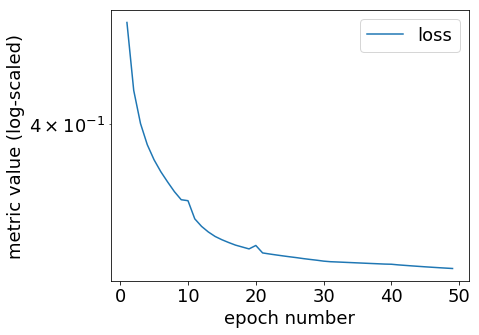

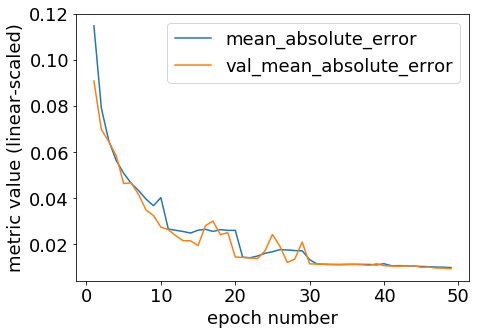

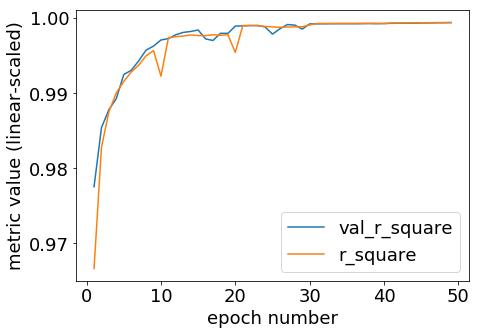

In [629]:
instance.plot_metrics(fnmatch_criteria="loss", yscale="log")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'all jet data (pred)']


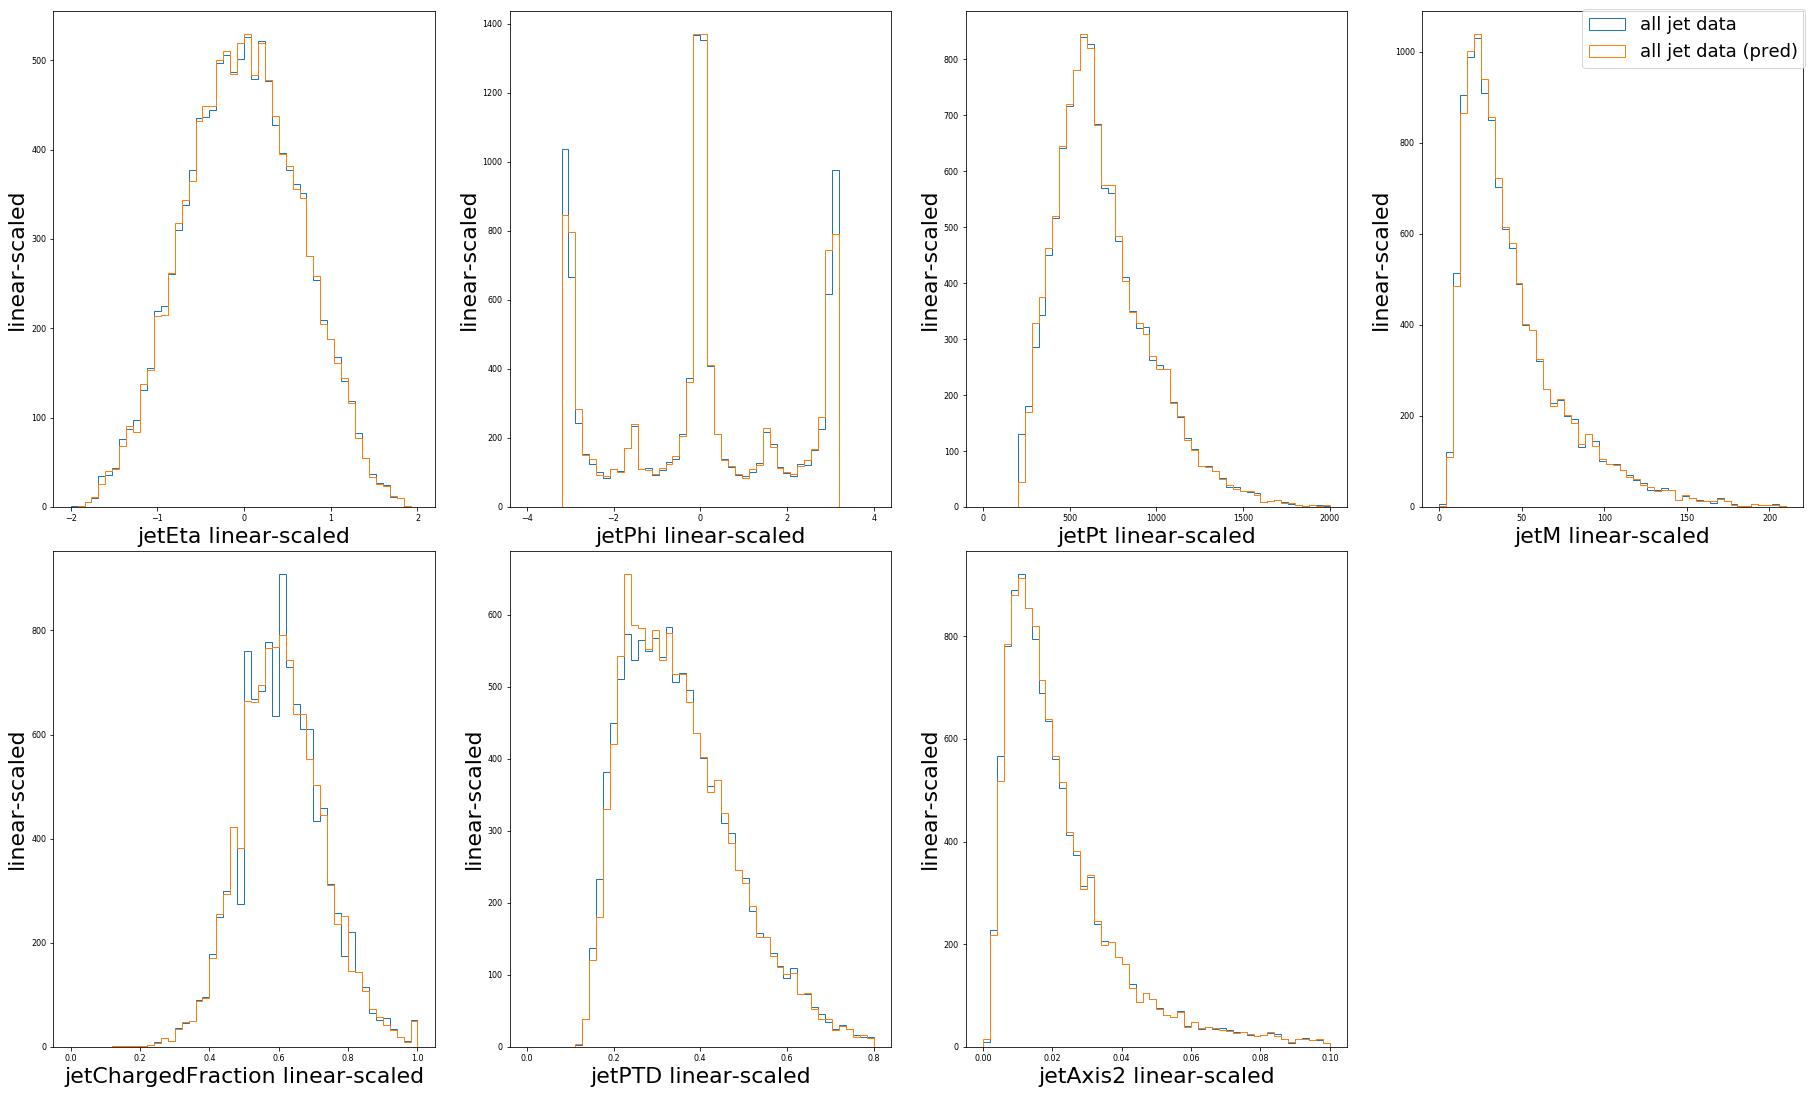

data_table :: plotting distrubution(s) for table(s) ["'all jet data' normed to 'all jet data'", 'untitled 462']


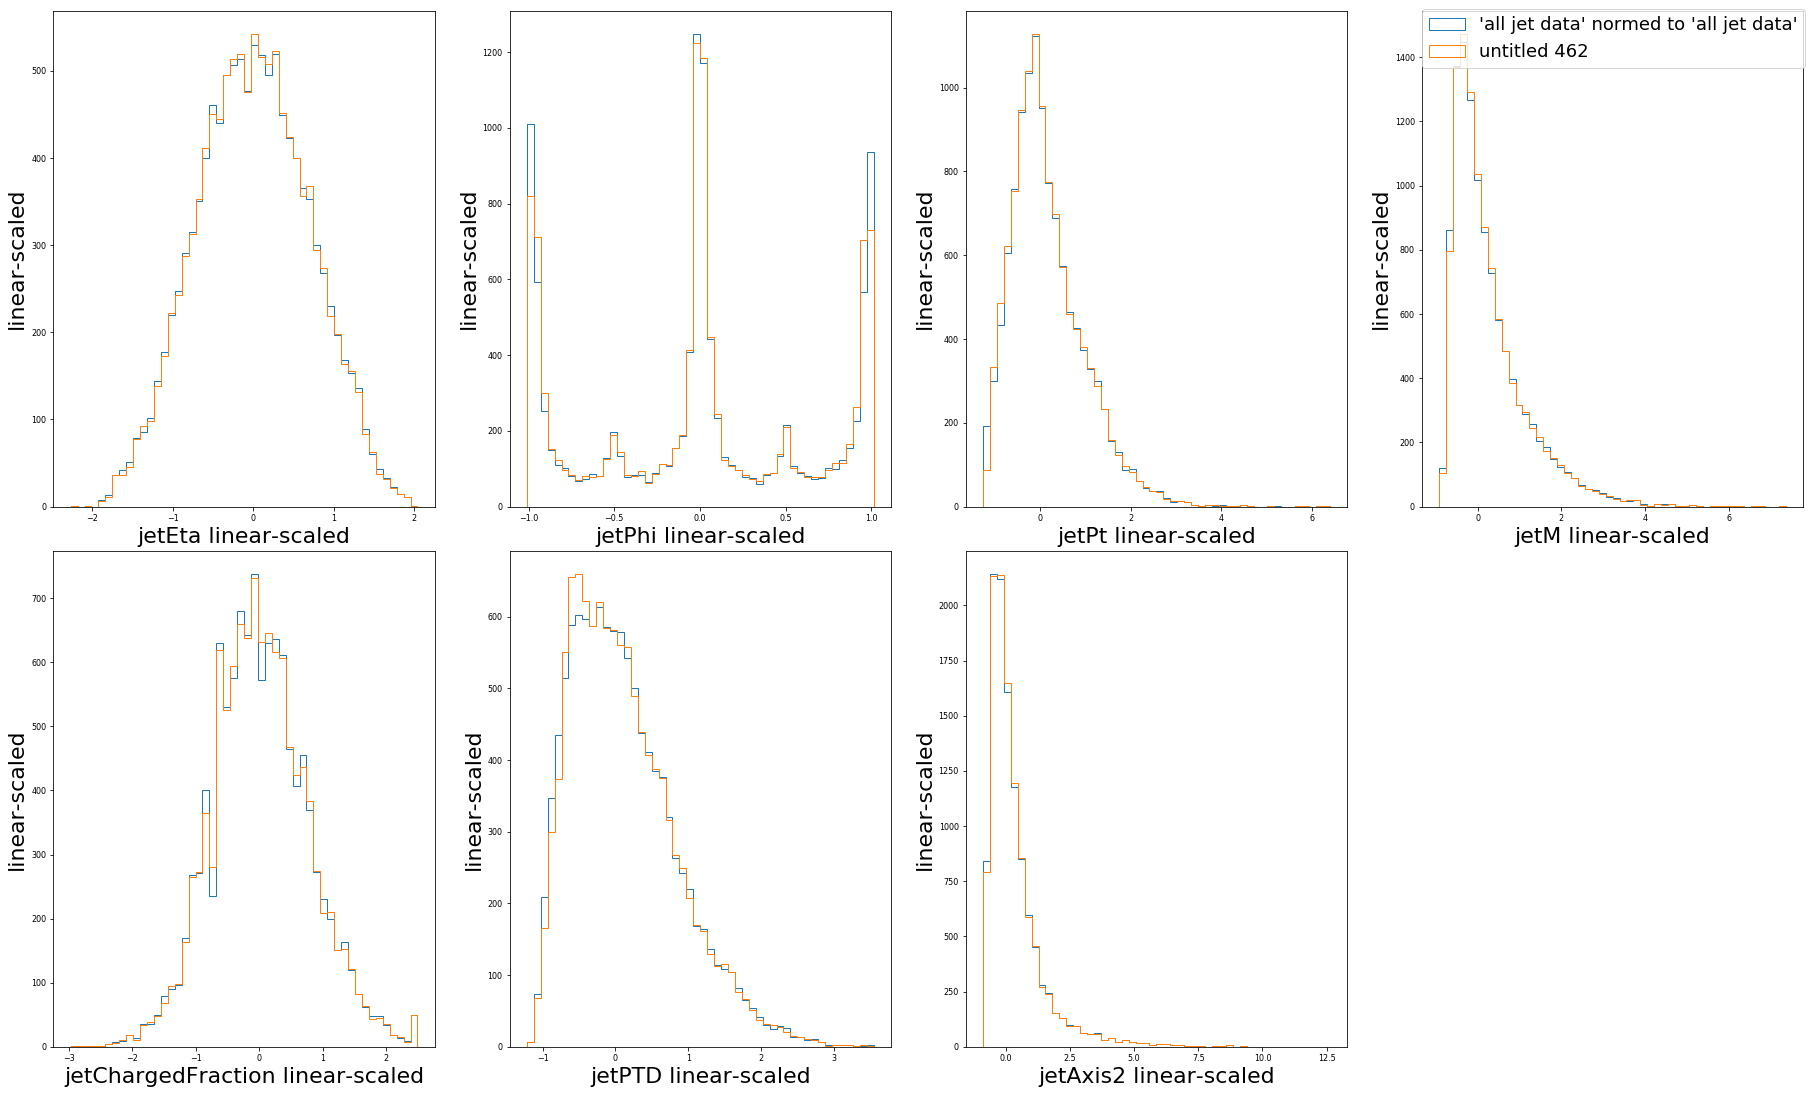

In [630]:

data_recon_norm = utils.data_table(autoencoder.predict(data.norm(**norm_args).df.values), headers=train_norm.headers)
data_recon = data.inorm(data_recon_norm, **norm_args)
data_recon.name = "all jet data (pred)"

# train_reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
# test_reconstructed_norm = data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)

# train_reconstructed = data.inorm(train_reconstructed_norm)
# # test_reconstructed = data.inorm(test_reconstructed_norm)


# train_reconstructed.name = "train reconstructed"
# test_reconstructed.name = "test reconstructed"

# train.plot([train_reconstructed], bins = 30, alpha=1.0)
# test.plot([test_reconstructed], bins=30, alpha=1.0)
data.plot(
#     [train_reconstructed, test_reconstructed],
    data_recon,
    normed=0, bins=50, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22, rng=[(-2,2), (-4,4), (0,2000), (0,210), (0,1), (0,0.8), (0, .10)]
)

data.norm(**norm_args).plot(
    data_recon_norm,
    normed=0, bins=50, alpha=1.0, figloc="upper right",
    figsize=(25,15), fontsize=22
)

In [631]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


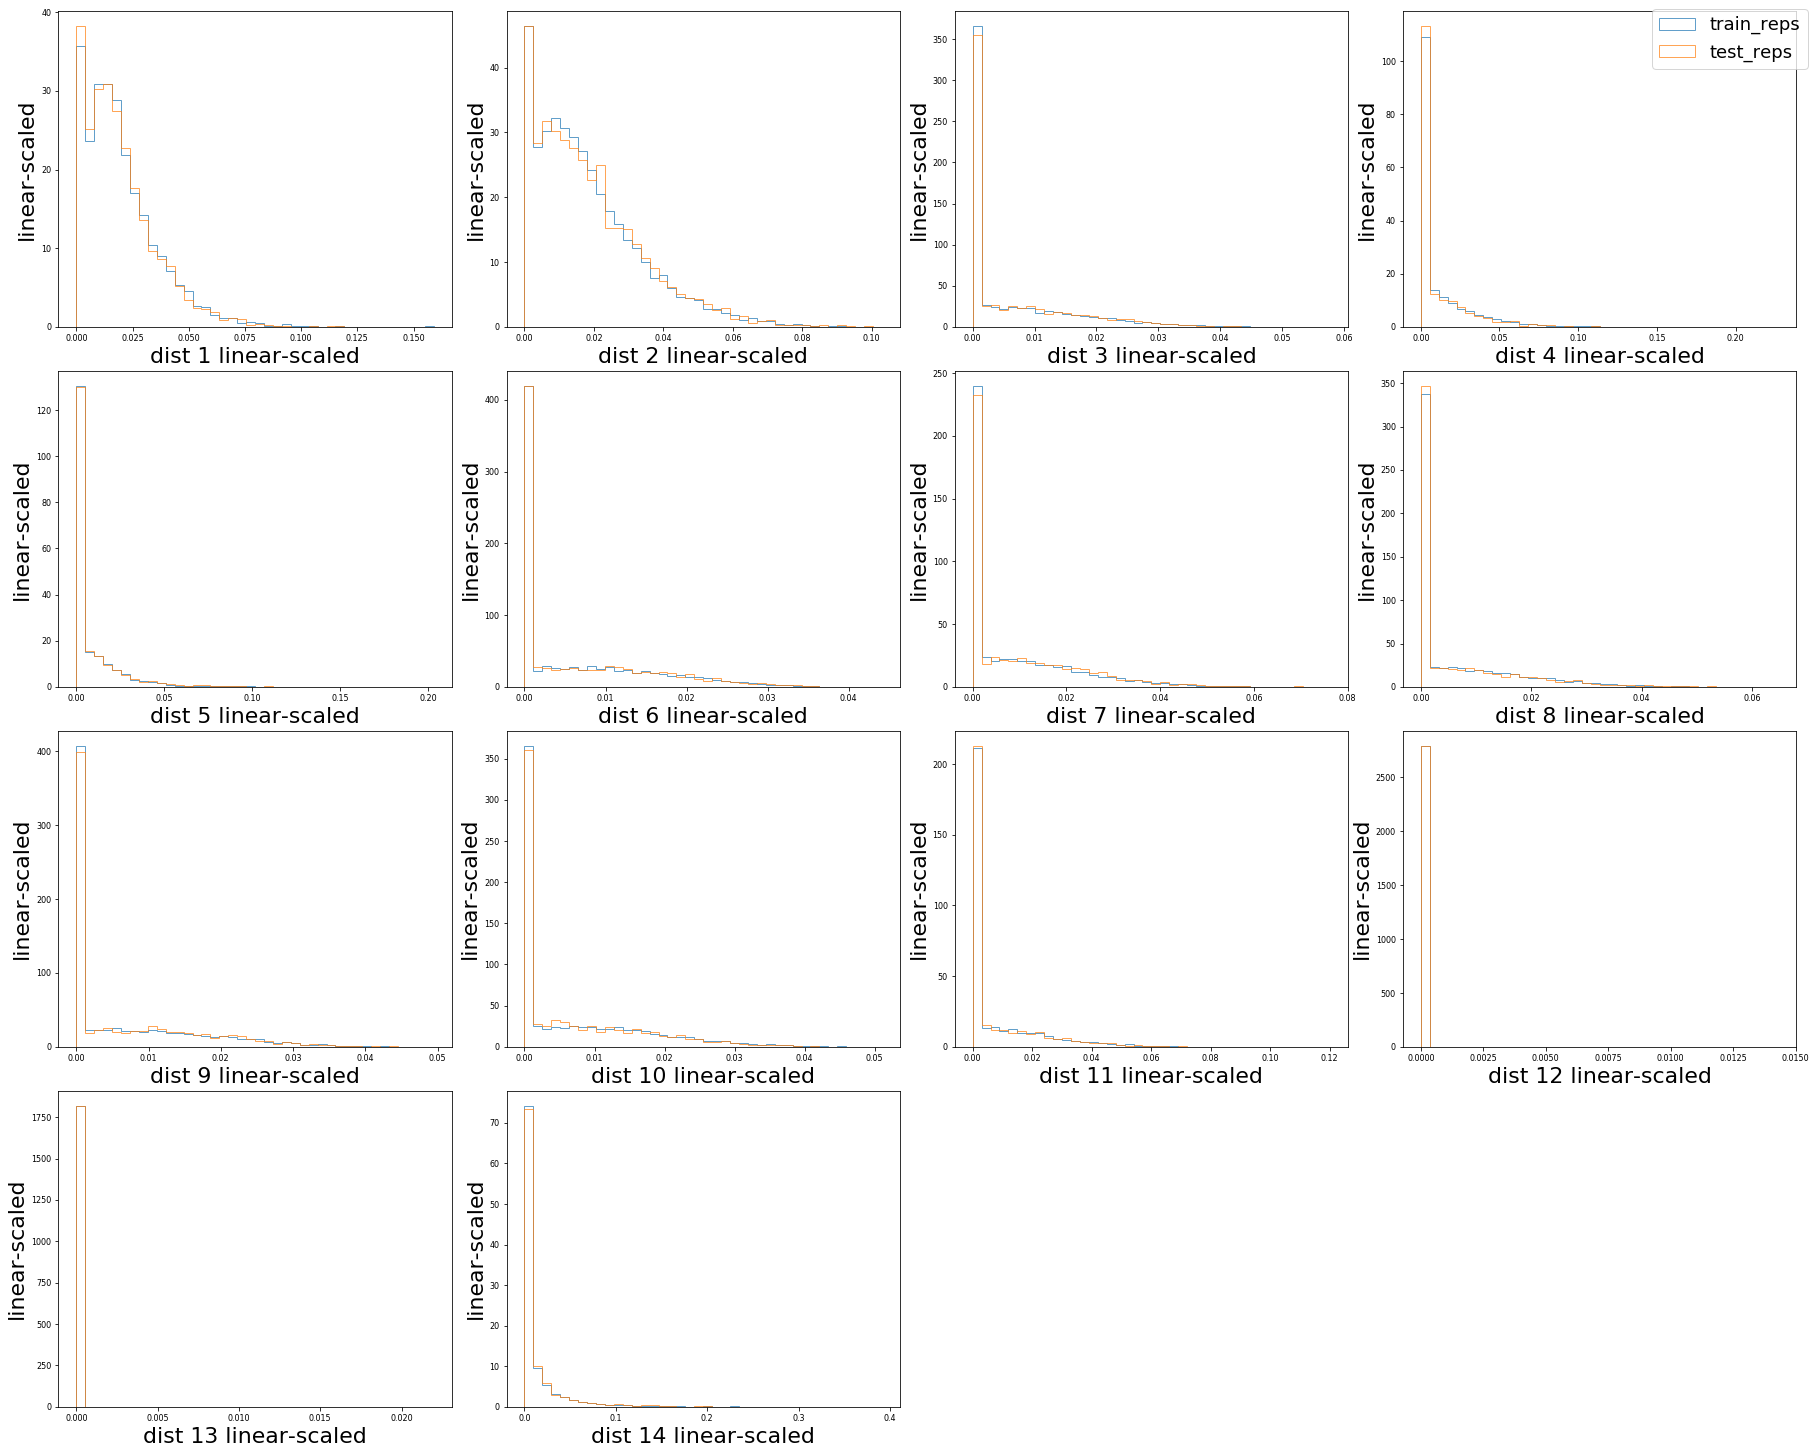

In [632]:
train_reps.plot([test_reps], cols=4, figsize=(25,20), fontsize=22, normed=1, bins=40)

In [633]:
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)

data_table :: plotting distrubution(s) for table(s) ['errors']


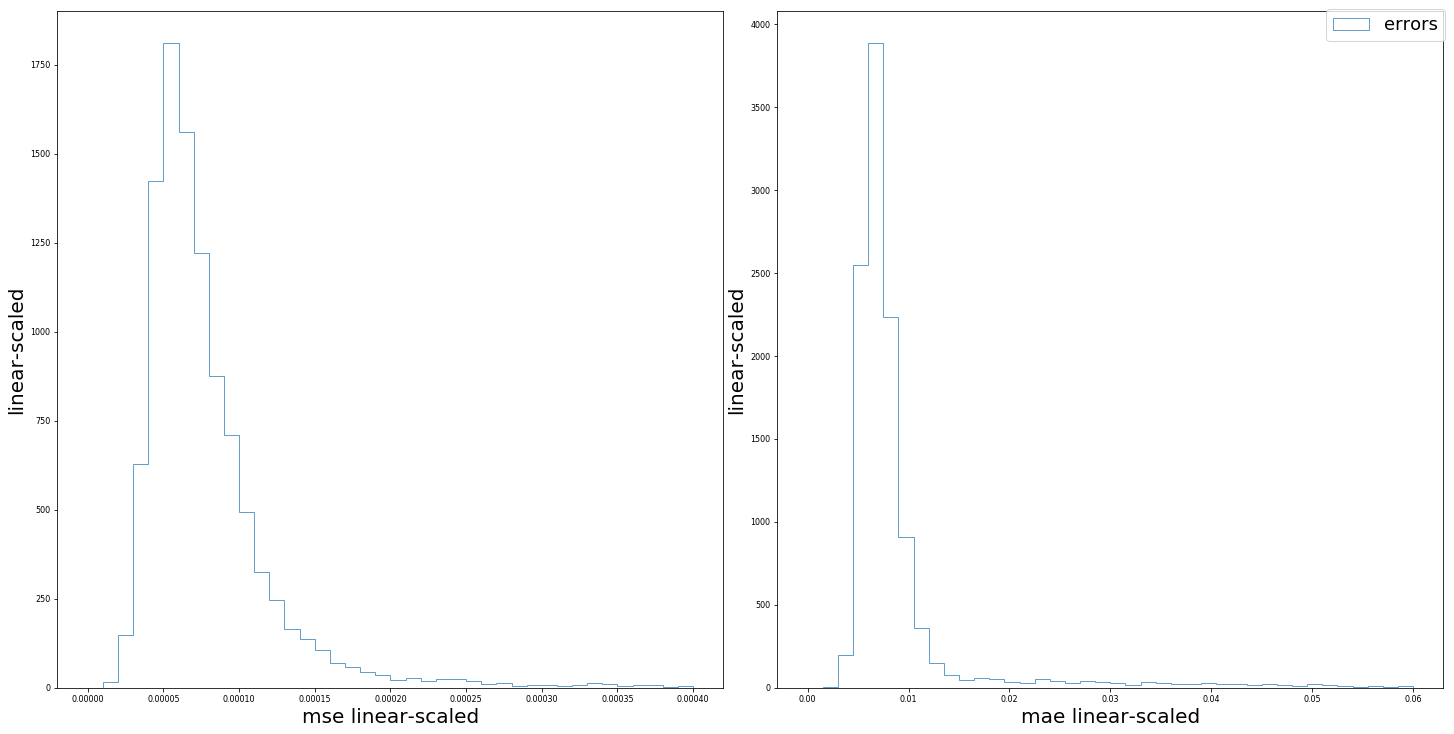

In [643]:
errors.plot(figsize=(20,10), bins=40, rng=((0,0.0004), (0, 0.06)), fontsize=20)

In [646]:
outlier_fraction = 0.01
index = np.argsort(errors.mae)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
print out_index.size + reg_index.size,len(errors)
print out_index.size, reg_index.size

11236 11236
112 11124


data_table :: plotting distrubution(s) for table(s) ['normal', 'outliers (top 0.01)']


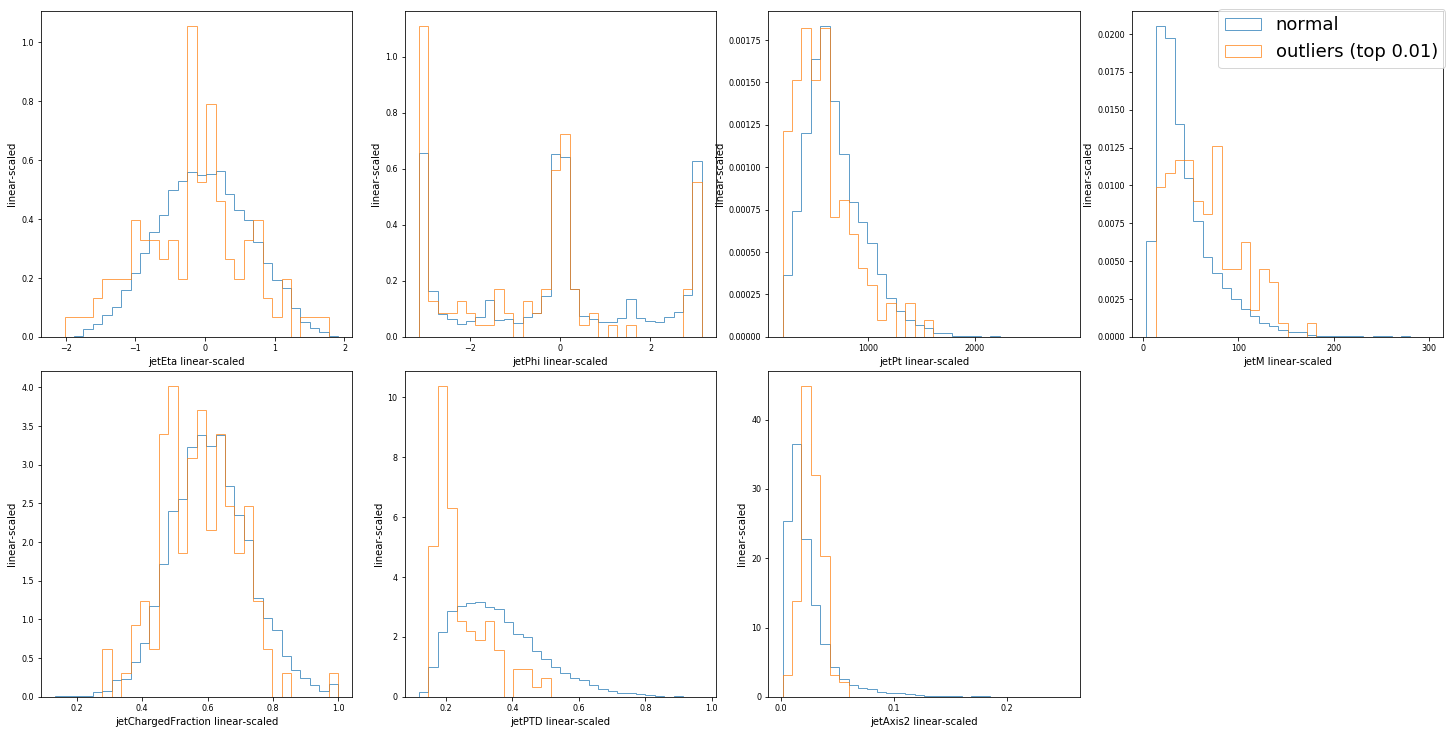

In [647]:
out,reg = (
    utils.data_table(data.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data.data[reg_index], headers=data.headers, name="normal")
)
reg.plot(out, normed=1, bins=30, figsize=(20,10))